In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import numpy as np

### read in and first cleaning

I had to divide my data into a few datasets while downloading from web analytics tools. That's why, below, I read in a few files and merge them.

The raw table has the following columns:
* sess_date: date of the session
* hour: hour of the hit
* minute: minute of the hit
* syn_ID: user ID 
* bounces: 1 if the session was a bounce (a non-engaged one)
* trans_id: transaction ID if there was a transaction made
* revenue: if there was a transaction, how much the customer paid
* session_source 
* session_medium
* session_campaign
* eventCategory: in my case, session_start, add_to_cart, add_to_favorites, check_availability_offline, and purchase


To clean it up:
* drop rows with no user ID,
* fill NaN's in columns: bounces, trans_id, revenue
* based on source, medium and campaign, define the channel that brought the user to the shop page


In [ ]:
files_to_read_in = ['file1.csv', 'file2.csv']

In [ ]:
df = pd.concat(
    map(pd.read_csv, files_to_read_in), ignore_index=True)
df.dropna(subset = ['syn_ID'])

### order in time

Merge sess_date, hour and minute into one column to sort user interactions in time.

In [11]:
df['sess_date'] = df['sess_date'].astype(str)
df['hour'] = df['hour'].astype(str).str.zfill(2)
df['minute'] = df['minute'].astype(str).str.zfill(2)
df['sess_date_time'] = df['sess_date'] + df['hour']  + df['minute']

In [ ]:
df_sel = df[["syn_ID","sess_date_time","channel","eventCategory","bounces"]]
df_sel.dropna(inplace=True)

Create a column with an interaction number. Then I can drop the "big" column sess_date_time.

In [ ]:
df_sel['num'] = df_sel.groupby(['syn_ID'])['sess_date_time'].rank(method='min')

df_sel.drop(columns=['sess_date_time'], inplace=True)

### paths

##### user ID mapping
because the ID column was too heavy to process (to not kill my computer)

In [5]:
syn_IDs = df_sel['syn_ID'].unique()  
id_dict = {}  

for i, syn_ID in enumerate(syn_IDs):
    id_dict[syn_ID] = i  

# create a new column with the mapped syn_IDs
df_sel['syn_ID_mapped'] = df_sel['syn_ID'].map(id_dict)

# drop old column
df_sel.drop('syn_ID', axis=1, inplace=True)

# rename new column
df_sel.rename(columns={'syn_ID_mapped': 'syn_ID'}, inplace=True)

##### column to create paths

In [3]:
# if user interaction is session_start, then I want the channel name, if not, I take the event fired on the page

df_sel['to_chann'] = np.where((df_sel['eventCategory'] == 'session') | (df_sel['eventCategory'] == 'bounce'),
                                df_sel['channel'], df_sel['eventCategory'])

# and now I can drop those old columns
df_sel.drop(['eventCategory','channel'], axis=1, inplace=True)

##### group by user ID - take all the interactions of one user and create user's path

In [5]:
df_paths = (df_sel.sort_values(by=['num']).groupby(['syn_ID'])
        .agg({'to_chann': lambda x: x.tolist()})
        .reset_index())

##### split paths so that one path would end while conversion

In [ ]:
df_paths['to_chann'] = df_paths['to_chann'].str.split('version')

,syn_ID,to_chann,sess
0,0,['start'|'google_p'|'other_t'|'other_t'|'other...,28
1,1,['start'|'other_t'|'other_t'|'other_t'|'other_...,39
2,1,['start'|'google_p'|'google_p'|'google_p'|'goo...,25
3,1,['start'|'other_p'|'other_p'|'other_p'|'other_...,13
4,2,['start'|'other_p'|'other_p'|'other_p'|'other_...,5
...,...,...,...
10732318,10144802,['start'|'retargeting'|'null'],1
10732319,10144803,['start'|'retargeting'|'retargeting'|'null'],2
10732320,10144804,['start'|'retargeting'|'null'],1
10732321,10144805,['start'|'retargeting'|'retargeting'|'null'],2


In [19]:
df_paths2 = df_paths.explode(['to_chann'])

##### exploded paths, counting sessions number

In [21]:
# I separated the paths on the 'conversion' word, so now I restore it  
df_paths2['to_chann'] = df_paths2['to_chann'].str.replace(r'con', 'conversion', regex=True)

,syn_ID,to_chann,sess
0,0,'start'|'google_p'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'seo'|'avail'|'other_t'|'other_t'|'ot...,28
1,1,'start'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t'|'other_t...,39
1,1,',39
2,1,'start'|'google_p'|'google_p'|'google_p'|'google_p'|'google_p'|'google_p'|'google_p'|'google_p'|'seo'|'seo'|'seo'|'seo'|'seo'|'seo'|'seo'|'other_p...,25
2,1,',25
3,1,'start'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'seo'|'seo'|'seo'|'seo'|'null',13
4,2,'start'|'other_p'|'other_p'|'other_p'|'other_p'|'avail'|'other_p'|'null',5
5,3,'start'|'other_p'|'other_p'|'other_p'|'other_p'|'cart'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'other_p'|'null',10
6,4,'start'|'other_t'|'other_t'|'avail'|'cart'|'null',2
7,5,'start'|'seo'|'cart'|'other_p'|'other_p'|'seo'|'other_p'|'affiliate'|'affiliate'|'other_p'|'affiliate'|'other_p'|'affiliate'|'other_p'|'other_p'|'...,15


In [18]:
df_paths2['to_chann'] = 'start|' + df_paths2['to_chann']

In [23]:
df_paths2['to_chann'] = df_paths2['to_chann'].str.split('|')

In [28]:
# count the number of sessions in each path
df_paths2['sess'] = df_paths2['to_chann'].apply(lambda x: len(x) - x.count('conversion') - x.count('null') - x.count('start') - x.count('cart') - x.count('avail') - x.count('fav'))

,syn_ID,to_chann,sess
0,0,"[start, google_p, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, seo, avail, other_t, other_t, other_t, avail, o...",28
1,1,"[start, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, other_t, oth...",39
1,1,[],1
2,1,"[start, google_p, google_p, google_p, google_p, google_p, google_p, google_p, google_p, seo, seo, seo, seo, seo, seo, seo, other_p, other_p, other...",25
2,1,[],1
...,...,...,...
10732318,10144802,"[start, retargeting, null]",1
10732319,10144803,"[start, retargeting, retargeting, null]",2
10732320,10144804,"[start, retargeting, null]",1
10732321,10144805,"[start, retargeting, retargeting, null]",2


##### I create  df_paths_lim, which is a data frame with paths shorter than the third quantile. 

In [ ]:
q3 = df_paths2['sessions_count'].quantile([0.75])

In [92]:
df_paths_lim = df_paths2[df_paths2['sessions_count'] <= q3]

In [30]:
# just in case - drop empty paths
df_paths_lim = df_paths_lim[df_paths_lim['to_chann'].map(len) > 1]

##### position-based models 

In [ ]:
# now I need only paths with conversion
df_paths_lim['is_con'] = df_paths_lim['to_chann'].apply(lambda x: 'conversion' in x)
df_paths_conv = df_paths2[df_paths2['is_conversion'] == 1]

In [ ]:
# take the first channel in the path
df_paths_conv['first_touch'] = df_paths_conv['channel'].str.split('|').str[1]

# take the last channel in the path
df_paths_conv['last_touch'] = df_paths_conv['channel'].str.split('|').str[-2]

In [ ]:
# count appearances of each channel in columns first_touch, last_touch in one table
chann_summ = df_paths_conv['first_touch'].value_counts().to_frame().join(df_paths_conv['last_touch'].value_counts().to_frame(), lsuffix='_first_touch', rsuffix='_last_touch')

In [ ]:
channel_list = ['google_t','google_p','social_t','social_p','other_t','other_p','retargeting','affiliate','compare','club','seo','direct']

for channel in channel_list:
    df_paths_conv[channel] = df_paths_conv['channel'].str.count(channel) / df_paths_conv['sess']

chann_linn = df_paths_conv[['google_t','google_p','social_t','social_p',
                            'other_t','other_p','retargeting','affiliate','compare','club','seo','direct']]

In [ ]:
chann_linn = chann_linn.drop(['sessions_count'], axis=1)

# total columns sum as dataframe with index
chann_linn_sum = chann_linn.sum().to_frame()
chann_linn_sum = chann_linn_sum.reset_index()
chann_linn_sum

In [ ]:
# rename columns in chann_linn_sum
chann_linn_sum = chann_linn_sum.rename(columns={'index':'channel',0: 'linear'})

# merge chann_linn_sum with chann_summ
chann_summ = chann_summ.reset_index()
chann_summ = chann_summ.rename(columns={'index':'channel'})
chann_summ = chann_summ.merge(chann_linn_sum, on='channel', how='left')
chann_summ['linear'] = chann_summ['linear'].fillna(0)
chann_summ['linear'] = chann_summ['linear'].round(1)

##### markov chains

In [ ]:
# WORKS ONLY FOR PATHS WITHOUT EVENTS
# so drop in each row avail, cart, fav
df_paths_lim['to_chann'] = df_paths_lim['to_chann'].apply(lambda x: [i for i in x if i != 'avail'])
df_paths_lim['to_chann'] = df_paths_lim['to_chann'].apply(lambda x: [i for i in x if i != 'cart'])
df_paths_lim['to_chann'] = df_paths_lim['to_chann'].apply(lambda x: [i for i in x if i != 'fav'])

In [34]:
list_of_paths = df_paths_lim['to_chann']
list_of_paths.dropna(inplace=True)

In [35]:
total_conversions =  list_of_paths.apply(lambda x: 'conversion' in x).sum()
print(total_conversions)
base_conversion_rate = total_conversions / len(list_of_paths)
print(base_conversion_rate)

441949
0.043007593662518225


In [36]:
list_of_unique_channels = []
for path in list_of_paths:
    for channel in path:
        if channel not in list_of_unique_channels:
            list_of_unique_channels.append(channel)

['start',
 'google_p',
 'other_t',
 'seo',
 'social_p',
 'affiliate',
 'null',
 'other_p',
 'conversion',
 'club',
 'retargeting',
 'social_t',
 'google_t',
 'direct',
 'compare',
 '']

In [37]:
transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

In [ ]:
for possible_state in list_of_unique_channels:
        if possible_state not in ['conversion', 'null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

In [18]:
from collections import defaultdict

In [40]:
trans_prob = defaultdict(dict)

def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    for state in list_of_unique_channels:
        if state not in ['conversion', 'null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob

trans_prob = transition_prob(transition_states)

In [41]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['conversion', 'null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

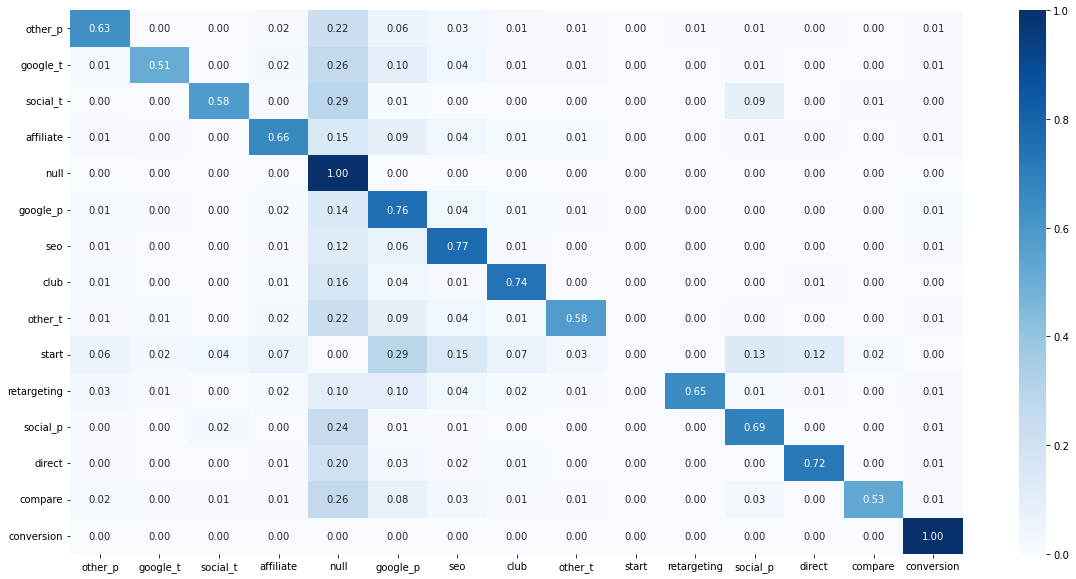

In [46]:
plt.figure(figsize=(20, 10))
sns.heatmap(trans_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.show()

##### removal effect

In [72]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['start',
                                                                     'null',
                                                                     'conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['null'] = null_pct
            removal_df.loc['null']['null'] = 1.0

        removal_to_conv = removal_df[
            ['null', 'conversion']].drop(['null', 'conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['null', 'conversion'], axis=1).drop(['null', 'conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [73]:
removal_effects_dict = {}
channels = [channel for channel in trans_matrix.columns if channel not in ['start', 'null', 'conversion']]

In [74]:
for channel in channels:
    removal_df = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)
    for column in removal_df.columns:
        row_sum = np.sum(list(removal_df.loc[column]))
        null_pct = float(1) - row_sum
        if null_pct != 0:
            removal_df.loc[column]['null'] = null_pct
        removal_df.loc['null']['null'] = 1.0
#    print(removal_df)

    removal_to_conv = removal_df[['null', 'conversion']].drop(['null', 'conversion'], axis=0)
    removal_to_non_conv = removal_df.drop(['null', 'conversion'], axis=1).drop(['null', 'conversion'], axis=0)

    removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
    removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
#    print(removal_dot_prod)

    removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['start'].values[0]
#    print(removal_cvr)
    removal_effect = 1 - removal_cvr / base_conversion_rate
    removal_effects_dict[channel] = removal_effect

In [76]:
re_sum = np.sum(list(removal_effects_dict.values()))

attributions =  {k: (v / re_sum) * total_conversions for k, v in removal_effects_dict.items()}
attributions

{'': 0.02171422178408883,
 'seo': 77599.16126865245,
 'compare': 5264.101419308696,
 'cart': 37375.22082375838,
 'fav': 6428.203373567762,
 'club': 19790.2480260936,
 'social_p': 28163.47950513172,
 'avail': 17988.307813322743,
 'google_p': 121000.65640102176,
 'retargeting': 5275.219698510449,
 'affiliate': 44990.28466722312,
 'other_t': 11641.227710324076,
 'other_p': 19820.744948517404,
 'direct': 31977.14556564027,
 'social_t': 6922.966521199283,
 'google_t': 7712.010543506501}

##### regression

In [6]:
# create logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
import statsmodels.api as sm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [9]:
# create X and y
df_paths2.dropna(inplace=True)
X = df_paths2[['sess','fav','avail','cart','google_t','google_p','social_t','social_p',
                'other_t','other_p','retargeting','affiliate','compare','club','seo','direct']]
y = df_paths2['is_conversion']

In [10]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [ ]:
logreg_first_try = LogisticRegression().fit(X_train, y_train)

In [34]:
# create df with coefficients and standard errors
coefficients = pd.DataFrame(logreg_first_try.coef_.T, index=X_train.columns, columns=['coefficients'])
coefficients['exp coeff'] = (lambda x: np.exp(x))(coefficients['coefficients'])
coefficients['standard errors'] = sm.Logit(y_train, X_train).fit().bse
coefficients['p-values'] = sm.Logit(y_train, X_train).fit().pvalues 
coefficients

,coefficients,exp coeff
sess,-0.855377,0.425123
fav,-0.057301,0.944310
avail,-0.087348,0.916358
cart,1.430867,4.182325
google_t,0.902493,2.465742
google_p,0.904888,2.471655
social_t,0.771117,2.162180
social_p,0.868441,2.383193
other_t,0.900213,2.460128
other_p,0.876813,2.403228
